In [9]:
from scipy.ndimage import affine_transform
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
from scipy.ndimage.interpolation import rotate
import subtle.subtle_preprocess as supre
import SimpleITK as sitk
from voxelmorph.tf.utils import invert_affine
import keras.backend as K

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

import nibabel as nib
plt.rcParams['figure.figsize'] = (10, 8)
plt.set_cmap('gray')

def process_brats_vol(img_vol, pad=False, is_seg=False):
    img_vol = np.rot90(img_vol.transpose(2, 0, 1), axes=(1, 2), k=3)
    img_vol = img_vol[13:-14]
    
    if not is_seg:
        img_vol = img_vol / img_vol.mean()
        img_vol = np.interp(img_vol, (img_vol.min(), img_vol.max()), (0, 1))
    
    if pad:
        img_vol = np.pad(img_vol, pad_width=[(0, 0), (8, 8), (8, 8)], mode='constant', constant_values=0)
    return img_vol

<Figure size 720x576 with 0 Axes>

20.0
[[ 1.  0.  0. 20.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]]


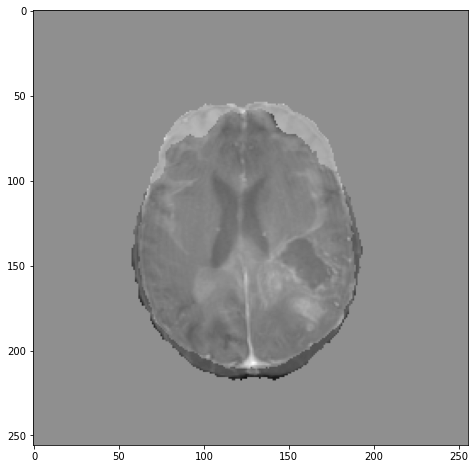

In [32]:
case_data = np.load('/home/srivathsa/projects/studies/gad/vmorph/data/brats/val/BraTS2021_00022.npz')
ref_data = process_brats_vol(
    nib.load('/home/srivathsa/projects/brats_2021/data/val/BraTS2021_00022/BraTS2021_00022_t1ce.nii.gz').get_fdata(),
    pad=True
)
fixed, _ = case_data['data']
aff = case_data['aff_mtx']

aff2 = np.eye(4)[:-1]
aff2[:, -1] = [20, 0, 0]
print(aff2[0, -1])
print(aff2)

ref_moved = affine_transform(ref_data, aff2)
diff = ref_moved - fixed
# plt.imshow(np.hstack([fixed[64], ref_moved[64], diff[64]]))
plt.imshow(diff[64])

In [ ]:
affn_data = np.load('/home/srivathsa/projects/studies/gad/vmorph/data/brats/val/BraTS2021_00022.npz')
img_fixed, img_moved = affn_data['data']
mtx = affn_data['aff_mtx']
mtx_inv = K.eval(invert_affine(mtx))

img_rest = affine_transform(img_moved, mtx_inv)

sl = 64

i1 = img_fixed[sl]
i2 = img_moved[sl]
i3 = img_rest[sl]
diff1 = i2 - i1
diff2 = i3 - i1

plt.imshow(np.hstack([i1, i2, i3]))

In [ ]:
plt.imshow(np.hstack([diff1, diff2]))

In [ ]:
data = np.load('/home/srivathsa/projects/studies/gad/vmorph/affine_data/sc/NO1.npz')['data'][0]

In [ ]:
# mtx = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]])

angle = 0
theta = -np.radians(angle)
sc = 1
tx = 0
ty = 0
mtx = np.array([[(1/sc) * np.cos(theta), -np.sin(theta), tx], 
                [np.sin(theta), (1/sc) * np.cos(theta), ty], 
                [0, 0, 1]
               ])
data_tfm = affine_transform(data[98], mtx)

In [ ]:
plt.imshow(data_tfm)

In [ ]:
fixed = data.copy()
print(fixed.min(), fixed.max())
moving = rotate(fixed, angle=-10, axes=(1, 2), mode='nearest', reshape=False)
mtx = np.array([[1, 0, 0, 0], [0, 1, 0, -13], [0, 0, 1, -13]])
moving = affine_transform(moving, mtx, mode='nearest')
print(moving.min(), moving.max())
print(fixed.dtype, moving.dtype)
plt.imshow(np.hstack([fixed[98], moving[98]]))

In [ ]:
pmap = sitk.GetDefaultParameterMap('affine')
moved, params = supre.register_im(fixed, moving, param_map=pmap)

In [ ]:
plt.imshow(moved[98])
print(moved.min(), moved.max())

In [ ]:
fixed, moving = np.load('/home/srivathsa/projects/studies/gad/vmorph/affine_data/sc/NO1.npz')['data']
pmap = sitk.GetDefaultParameterMap('affine')
moved_sitk, params = supre.register_im(fixed, moving, param_map=pmap)

In [ ]:
params[0]['TransformParameters']

In [ ]:
mtx = np.array([
    [0.996301, 0.00638798, -0.00292411, 0.0405367],
    [-0.00596, 0.990403, -0.00756067, 0.235278],
    [0.00261286, 0.00897077, 0.993402, -0.121042]
])
moving_tfm = affine_transform(moving, mtx)

In [ ]:
plt.imshow(np.hstack([fixed[98], moving_tfm[98], moving_tfm[98]-fixed[98]]))

In [ ]:
fixed = nib.load('/home/srivathsa/projects/brats_2021/data/train/BraTS2021_00000/BraTS2021_00000_t1.nii.gz').get_data()
fixed = fixed / fixed.mean()
fixed = np.interp(fixed, (fixed.min(), fixed.max()), (0, 1))
moving = nib.load('/home/srivathsa/projects/brats_2021/data/train/BraTS2021_00000/BraTS2021_00000_t1ce.nii.gz').get_data()
moving = moving / moving.mean()
moving = np.interp(moving, (moving.min(), moving.max()), (0, 1))

In [ ]:
moving_tfm = affine_transform(moving, mtx)

In [ ]:
plt.imshow(moving_tfm[..., 80] - fixed[..., 80])